In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

from torch.nn.parameter import Parameter
import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat
#Set default dtype to float32
torch.set_default_dtype(torch.float)

from smt.sampling_methods import LHS
#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:2


In [2]:
data = scipy.io.loadmat('burgers_shock_10sin.mat')
label = "QCRE_2D_5_tanhxtanh_NW"
                     
x_test = data['x']                                   # 256 points between -1 and 1 [256x1]
t_test = data['t']   
usol = data['usol']
X_test, T_test = np.meshgrid(x_test,t_test)  

xt_test_tensor = torch.from_numpy(np.hstack((X_test.flatten()[:,None], T_test.flatten()[:,None]))).float().to(device)

u_true = usol.flatten('F')[:,None]

In [3]:
# data = scipy.io.loadmat('burgers_shock_10sin.mat')  	# Load data from file

pi = torch.from_numpy(np.array(np.pi)).double().to(device)

label = "QCRE_2D_5_tanhxtanh_NW"
# x = data['x']                                   # 256 points between -1 and 1 [256x1]
# t = data['t']                                   # 100 time points between 0 and 0.2 [100x1] 
# usol = data['usol']   

#usol = usol/1000# solution of 256x100 grid points

x = np.linspace(-1,1,500).reshape(-1,1)
t = np.linspace(0,0.2,500).reshape(-1,1)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))

#y_true = true_2D_1(xt)

bound_pts_1 = (X==-1).reshape(-1,)
xt_bound_1 = xt[bound_pts_1,:]
u_bound_1 = np.zeros((np.shape(xt_bound_1)[0],1))

bound_pts_2 = (X==1).reshape(-1,)
xt_bound_2 = xt[bound_pts_2,:]
u_bound_2 = np.zeros((np.shape(xt_bound_2)[0],1))

bound_pts_3 = (T==0).reshape(-1,)
xt_bound_3 = xt[bound_pts_3,:]
u_bound_3 = -10*np.sin(np.pi*xt_bound_3[:,0].reshape(-1,1))
#u_bound_3 = -10*np.ones((np.shape(bound_pts_3)[0],1))


xt_bound = np.vstack((xt_bound_1,xt_bound_2,xt_bound_3))
u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3))


lb_xt = xt[0]
ub_xt = xt[-1]

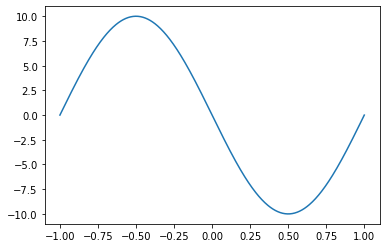

In [4]:
plt.plot(xt_bound_3[:,0],u_bound_3)

In [5]:
def trainingdata(N_u,N_f,seed):

    '''Boundary Conditions'''
    #Initial Condition -1 =< x =<1 and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]

#     #Boundary Condition x = -1 and 0 =< t =<1
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[-1,:][:,None]

#     #Boundary Condition x = 1 and 0 =< t =<1
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[0,:][:,None]

#     all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
#     all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    np.random.seed(seed)
    idx = np.random.choice(xt_bound.shape[0], N_u, replace=True) 

    X_u_train = xt_bound[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = u_bound[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    X_f_train = lb_xt + (ub_xt-lb_xt)*samples 
    
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train

In [6]:
#X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
X_u_test = xt_test_tensor
# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
#u_true = usol.flatten('F')[:,None]

"\n   Fortran Style ('F') flatten,stacked column wise!\n   u = [c1 \n        c2\n        .\n        .\n        cn]\n\n   u =  [25600x1] \n"

In [12]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        self.beta = Parameter(1*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        self.beta_val = []
        
        self.W1 = Parameter(torch.tensor(0.0))
        self.W1.requiresGrad = True
        
        self.W2 = Parameter(torch.tensor(0.0))
        self.W2.requiresGrad = True
        
    'foward pass'
    def forward(self,x):
         if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
         u_b = torch.from_numpy(ub_xt).float().to(device)
         l_b = torch.from_numpy(lb_xt).float().to(device)
        
            
         #preprocessing input 
         x = (x - l_b)/(u_b - l_b) #feature scaling
        
         #convert to float
         a = x.float()
                        
         '''     
         Alternatively:
        
         a = self.activation(self.fc1(a))
         a = self.activation(self.fc2(a))
         a = self.activation(self.fc3(a))
         a = self.fc4(a)
         
         '''
        
         for i in range(len(layers)-2):
                z = self.linears[i](a)
                a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
         
         a = self.linears[-1](a)
        
         return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(torch.sum(self.forward(x)), y)
                
        return loss_u
    
    def loss_BC_fake(self,x):
        
        loss_u = self.loss_function(self.forward(x)[:,0],self.forward(x)[:,1])
        
        return loss_u
    
    def loss_PDE(self, x_to_train_f,f_hat):
        
        nu = 0.01/pi
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)[:,[0]]
        
                
        #print(u.shape)
        u_x_t = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss_PDE_fake(self, x_to_train_f,f_hat):
        
        nu = 0.01/pi
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)[:,[1]]
                
        u_x_t = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f_fake
    
    def loss(self,x,y,x_to_train_f,f_hat):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f,f_hat)
        
        loss_u_fake = self.loss_BC_fake(x)
        loss_f_fake = self.loss_PDE(x_to_train_f,f_hat)
     
        
        loss_val = loss_u + loss_f + loss_u_fake + loss_f_fake
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
#         X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f,self.iter*32)
        
#         X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
#         X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
#         u_train = torch.from_numpy(u_train_np_array).float().to(device)
        
#     #u = torch.from_numpy(u_true).float().to(device)
#         f_hat = torch.zeros(X_f_train.shape[0],1).to(device)
        

        loss = self.loss(X_u_train, u_train, X_f_train,f_hat)
        
        self.train_loss.append(loss.cpu().detach().numpy())
        
        
        u_pred = self.test(xt_test_tensor)
        self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1))))
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
#         print(self.iter,"Train Loss",self.train_loss[-1])
        loss.backward()
        self.iter += 1
     
        return loss        
    'test neural network'
    
    def test(self,xt_test_tensor):
        u_pred = self.forward(xt_test_tensor)[:,[0]]
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [8]:
xt_test_tensor

tensor([[-1.0000,  0.0000],
        [-0.9922,  0.0000],
        [-0.9843,  0.0000],
        ...,
        [ 0.9843,  0.2000],
        [ 0.9922,  0.2000],
        [ 1.0000,  0.2000]], device='cuda:2')

In [13]:
max_reps = 1

train_loss_full = []
test_loss_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))


for reps in range(max_reps):
    print(reps)
    N_u = 1000 #Total number of data points for 'u'
    N_f = 10000 #Total number of collocation points 
    
    X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f,reps*32)
        
    X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
    X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
        
    #u = torch.from_numpy(u_true).float().to(device)
    f_hat = torch.zeros(X_f_train.shape[0],1).to(device)
        

    #X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
    'Convert to tensor and send to GPU'


    layers = np.array([2,50,50,50,50,50,50,50,50,50,2]) #9 hidden layers

    #layers = np.array([2,512,512,1])
    PINN = Sequentialmodel(layers)
       
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())

    
    
    'L-BFGS Optimizer'
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                                  max_iter = 500, 
                                  max_eval = None, 
                                  tolerance_grad = -1, 
                                  tolerance_change = -1, 
                                  history_size = 100, 
                                  line_search_fn = 'strong_wolfe')

    start_time = time.time()

    for opt in range(10):
        print(opt)
        optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    beta_full.append(PINN.beta_val)
    

mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)
0
0 Train Loss 65163.992 Test Loss 24.83290042880723
1 Train Loss 15019.376 Test Loss 24.77008874393443
2 Train Loss 229.10286 Test Loss 24.726353861248366
3 Train Loss 36.496555 Test Loss 24.721491459576672
4 Train Loss 36.08051 Test Loss 24.721241415301137
5 Train Loss 36.07933 Test Loss 24.721222

143 Train Loss 17.485994 Test Loss 24.566217788818204
144 Train Loss 17.485987 Test Loss 24.566731359246273
145 Train Loss 17.485983 Test Loss 24.566757729965843
146 Train Loss 17.485981 Test Loss 24.566760695642692
147 Train Loss 17.485994 Test Loss 24.566217788818204
148 Train Loss 17.485987 Test Loss 24.566731359246273
149 Train Loss 17.485983 Test Loss 24.566757729965843
150 Train Loss 17.485981 Test Loss 24.566760695642692
151 Train Loss 17.485994 Test Loss 24.566217788818204
152 Train Loss 17.485987 Test Loss 24.566731359246273
153 Train Loss 17.485983 Test Loss 24.566757729965843
154 Train Loss 17.485981 Test Loss 24.566760695642692
155 Train Loss 17.485994 Test Loss 24.566217788818204
156 Train Loss 17.485987 Test Loss 24.566731359246273
157 Train Loss 17.485983 Test Loss 24.566757729965843
158 Train Loss 17.485981 Test Loss 24.566760695642692
159 Train Loss 17.485994 Test Loss 24.566217788818204
160 Train Loss 17.485987 Test Loss 24.566731359246273
161 Train Loss 17.485983 Tes

296 Train Loss 17.485987 Test Loss 24.566731359246273
297 Train Loss 17.485983 Test Loss 24.566757729965843
298 Train Loss 17.485981 Test Loss 24.566760695642692
299 Train Loss 17.485994 Test Loss 24.566217788818204
300 Train Loss 17.485987 Test Loss 24.566731359246273
301 Train Loss 17.485983 Test Loss 24.566757729965843
302 Train Loss 17.485981 Test Loss 24.566760695642692
303 Train Loss 17.485994 Test Loss 24.566217788818204
304 Train Loss 17.485987 Test Loss 24.566731359246273
305 Train Loss 17.485983 Test Loss 24.566757729965843
306 Train Loss 17.485981 Test Loss 24.566760695642692
307 Train Loss 17.485994 Test Loss 24.566217788818204
308 Train Loss 17.485987 Test Loss 24.566731359246273
309 Train Loss 17.485983 Test Loss 24.566757729965843
310 Train Loss 17.485981 Test Loss 24.566760695642692
311 Train Loss 17.485994 Test Loss 24.566217788818204
312 Train Loss 17.485987 Test Loss 24.566731359246273
313 Train Loss 17.485983 Test Loss 24.566757729965843
314 Train Loss 17.485981 Tes

449 Train Loss 17.485983 Test Loss 24.566757729965843
450 Train Loss 17.485981 Test Loss 24.566760695642692
451 Train Loss 17.485994 Test Loss 24.566217788818204
452 Train Loss 17.485987 Test Loss 24.566731359246273
453 Train Loss 17.485983 Test Loss 24.566757729965843
454 Train Loss 17.485981 Test Loss 24.566760695642692
455 Train Loss 17.485994 Test Loss 24.566217788818204
456 Train Loss 17.485987 Test Loss 24.566731359246273
457 Train Loss 17.485983 Test Loss 24.566757729965843
458 Train Loss 17.485981 Test Loss 24.566760695642692
459 Train Loss 17.485994 Test Loss 24.566217788818204
460 Train Loss 17.485987 Test Loss 24.566731359246273
461 Train Loss 17.485983 Test Loss 24.566757729965843
462 Train Loss 17.485981 Test Loss 24.566760695642692
463 Train Loss 17.485994 Test Loss 24.566217788818204
464 Train Loss 17.485987 Test Loss 24.566731359246273
465 Train Loss 17.485983 Test Loss 24.566757729965843
466 Train Loss 17.485981 Test Loss 24.566760695642692
467 Train Loss 17.485994 Tes

602 Train Loss 17.485981 Test Loss 24.566760695642692
603 Train Loss 17.485994 Test Loss 24.566217788818204
604 Train Loss 17.485987 Test Loss 24.566731359246273
605 Train Loss 17.485983 Test Loss 24.566757729965843
606 Train Loss 17.485981 Test Loss 24.566760695642692
607 Train Loss 17.485994 Test Loss 24.566217788818204
608 Train Loss 17.485987 Test Loss 24.566731359246273
609 Train Loss 17.485983 Test Loss 24.566757729965843
610 Train Loss 17.485981 Test Loss 24.566760695642692
611 Train Loss 17.485994 Test Loss 24.566217788818204
612 Train Loss 17.485987 Test Loss 24.566731359246273
613 Train Loss 17.485983 Test Loss 24.566757729965843
614 Train Loss 17.485981 Test Loss 24.566760695642692
615 Train Loss 17.485994 Test Loss 24.566217788818204
616 Train Loss 17.485987 Test Loss 24.566731359246273
617 Train Loss 17.485983 Test Loss 24.566757729965843
618 Train Loss 17.485981 Test Loss 24.566760695642692
619 Train Loss 17.485994 Test Loss 24.566217788818204
620 Train Loss 17.485987 Tes

KeyboardInterrupt: 

In [ ]:
PINN.W2

In [ ]:
u_pred = PINN.test(xt_test_tensor)

cmap = plt.cm.rainbow
plt.imshow(u_pred.reshape(100,256),cmap = cmap,aspect =1,vmin=-10,vmax=10)

In [ ]:
X_u_train

In [ ]:
np.min(u_pred)

In [ ]:
np.max(u_pred)

In [ ]:
cmap = plt.cm.rainbow
plt.imshow(u_true.reshape(100,256),cmap = cmap,aspect = 1,vmin=-10,vmax=10)

In [ ]:
np.min(u_true)

In [ ]:
cmap = plt.cm.rainbow
plt.imshow(np.transpose(np.abs(u_pred - u_true).reshape(100,256)),cmap = cmap,aspect = 0.2)

In [ ]:
a = 0 
for i in range(10):
    print(test_loss_full[i][-1])
    a = a + test_loss_full[i][-1]
print(a/10)